In [153]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [154]:
df = pd.read_csv("data/housing.csv")

In [155]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


<Axes: xlabel='median_house_value', ylabel='Count'>

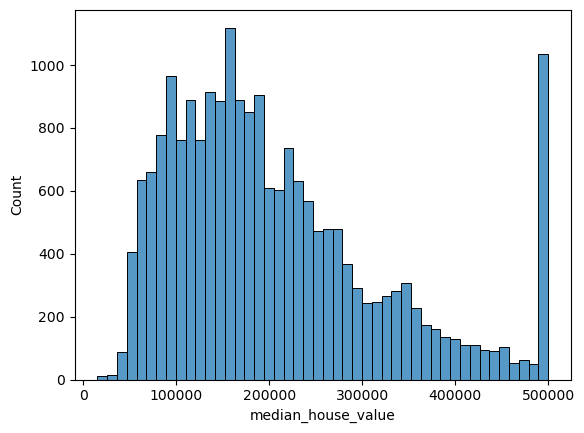

In [156]:
sns.histplot(df.median_house_value)

In [157]:
df_f = df[(df.ocean_proximity == "<1H OCEAN") | (df.ocean_proximity == "INLAND")]

In [158]:
df_f = df_f[
    [
        "latitude",
        "longitude",
        "housing_median_age",
        "total_rooms",
        "total_bedrooms",
        "population",
        "households",
        "median_income",
        "median_house_value",
    ]
]

In [159]:
df_f.isnull().sum()  # total_bedrooms

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

In [160]:
df_f.population.describe()  # 1195

count    15687.000000
mean      1466.317205
std       1180.389908
min          3.000000
25%        802.000000
50%       1195.000000
75%       1777.000000
max      35682.000000
Name: population, dtype: float64

In [161]:
from sklearn.model_selection import train_test_split

target = "median_house_value"

df_f[target] = np.log1p(df_f[target])
seed = 42
X_train, X_test, y_train, y_test = train_test_split(
    df_f.drop(target, axis=1), df_f[target], test_size=0.2, random_state=seed
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=seed
)

In [162]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((9411, 8), (3138, 8), (3138, 8), (9411,), (3138,), (3138,))

In [163]:
def fill_null(df, col, value):
    df_result = df.copy()
    df_result[col].fillna(value, inplace=True)
    return df_result

In [164]:
null_coll = "total_bedrooms"
X_train_0 = fill_null(X_train, null_coll, 0)
X_val_0 = fill_null(X_val, null_coll, 0)
X_test_0 = fill_null(X_test, null_coll, 0)

In [165]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [166]:
w0, w = train_linear_regression(X_train_0, y_train)

In [167]:
w0, w

(-10.177250731185966,
 array([-2.76754423e-01, -2.62387252e-01,  1.40815345e-03, -1.58875063e-05,
         2.55864744e-04, -1.88037540e-04,  4.12519906e-04,  1.73219249e-01]))

In [168]:
y_pred_val = w0 + X_val_0.dot(w)
rmse_sklearn = mean_squared_error(y_val, y_pred_val, squared=False)
print(round(rmse_sklearn, 2))

0.34


In [169]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [170]:
manual_rmse = rmse(y_val, y_pred_val)
print(round(manual_rmse, 2))

0.34


<Axes: xlabel='median_house_value', ylabel='Count'>

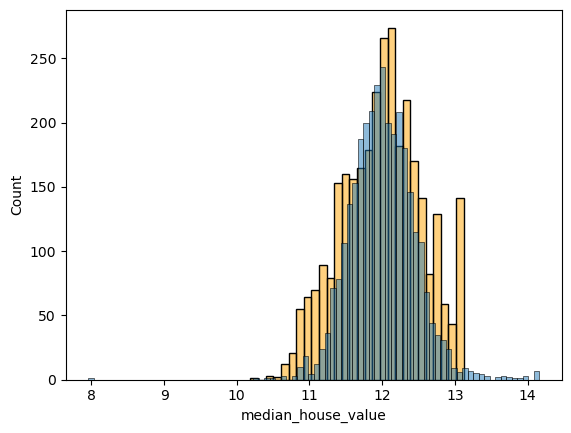

In [171]:
sns.histplot(y_val, color="orange", alpha=0.5)
sns.histplot(y_pred_val, alpha=0.5)

In [172]:
# model = LinearRegression()
# model.fit(X_train_0, y_train)
# predictions_val = model.predict(X_val_0)
# rmse = mean_squared_error(y_val, predictions_val, squared=False)

In [173]:
# print("Substition of nulls with 0: rmse = ", round(rmse, 2))

In [174]:
train_mean = X_train.total_bedrooms.mean()

In [175]:
X_train_m = fill_null(X_train, null_coll, train_mean)
X_val_m = fill_null(X_val, null_coll, train_mean)
X_test_m = fill_null(X_test, null_coll, train_mean)

In [176]:
w0, w = train_linear_regression(X_train_m, y_train)

In [177]:
y_pred_val = w0 + X_val_m.dot(w)
rmse_sklearn = mean_squared_error(y_val, y_pred_val, squared=False)
print(round(rmse_sklearn, 2))

0.33


In [178]:
manual_rmse = rmse(y_val, y_pred_val)
print(round(manual_rmse, 2))

0.33


If use functions from videos, rmse for data with fillna with mean value gives slightly smaller error. If using LinearRegression from sklearn_ then both models are equally good.

In [179]:
# model = LinearRegression()
# model.fit(X_train_m, y_train)
# predictions_val = model.predict(X_val_m)
# rmse = mean_squared_error(y_val, predictions_val, squared=False)

In [180]:
# print("Substition of nulls with mean: rmse = ", round(rmse, 2))  # Both are equally good

In [181]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [182]:
reg_par = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

In [183]:
for r in reg_par:
    w0, w = train_linear_regression_reg(X_train_0, y_train, r=r)

    y_pred = w0 + X_val_0.dot(w)
    score = rmse(y_val, y_pred)

    print(r, w0, score)  # 0

0 -10.177250731185966 0.33537270160811605
1e-06 -10.177229697382524 0.3353726989883921
0.0001 -10.175147812930119 0.33537243978674924
0.001 -10.156260571093767 0.3353701183501148
0.01 -9.971173231289324 0.3353502382141187
0.1 -8.43405953968933 0.33538636164877816
1 -3.3172350049915345 0.3380836493429903
5 -0.895453090500023 0.3407219246388255
10 -0.4669518006147436 0.3412784179525116


In [184]:
scores = []
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    X_train, X_test, y_train, y_test = train_test_split(
        df_f.drop(target, axis=1), df_f[target], test_size=0.2, random_state=seed
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.25, random_state=seed
    )
    X_train_0 = fill_null(X_train, null_coll, 0)
    X_val_0 = fill_null(X_val, null_coll, 0)
    w0, w = train_linear_regression(X_train_0, y_train)
    y_pred_val = w0 + X_val_0.dot(w)
    manual_rmse = rmse(y_val, y_pred_val)
    print("seed = ", seed, "rmse = ", round(manual_rmse, 2))
    scores.append(manual_rmse)

seed =  0 rmse =  0.33
seed =  1 rmse =  0.34
seed =  2 rmse =  0.33
seed =  3 rmse =  0.34
seed =  4 rmse =  0.33
seed =  5 rmse =  0.34
seed =  6 rmse =  0.34
seed =  7 rmse =  0.34
seed =  8 rmse =  0.34
seed =  9 rmse =  0.35


In [185]:
round(np.std(scores), 3)

0.006

In [186]:
seed = 9
X_train, X_test, y_train, y_test = train_test_split(
    df_f.drop(target, axis=1), df_f[target], test_size=0.2, random_state=seed
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=seed
)
X_train_0 = fill_null(X_train, null_coll, 0)
X_val_0 = fill_null(X_val, null_coll, 0)
X_test_0 = fill_null(X_test, null_coll, 0)
X_full_train = pd.concat([X_train_0, X_val_0])

In [187]:
y_full_train = pd.concat([y_train, y_val])

In [188]:
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)
y_pred_test = w0 + X_test_0.dot(w)
manual_rmse = rmse(y_test, y_pred_test)
manual_rmse

0.3468032308836845